In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm

In [2]:
df = pd.read_csv('../data/AB_NYC_2019.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.shape

(48895, 16)

In [5]:
# We transform latitude and longitude in UTM coordinates. Because the Earth portion at which we are looking is quite small, UTM provides enough accuracy.
df['utm'] = df.apply(lambda row : utm.from_latlon(row.latitude, row.longitude)[:2], axis=1)
df['utm_x'] = df.apply(lambda row : row.utm[0], axis=1)
df['utm_y'] = df.apply(lambda row : row.utm[1], axis=1)

In [6]:
df = df.drop(columns=['name', 'host_name', 'minimum_nights', 'last_review', 'latitude', 'longitude']) #We drop the features we won't use
#df = df[df.reviews_per_month.notna()] # we drop the airbnb without review_per_month
df = df[df.availability_365 != 0] # We drop Airbnb that are not available

In [7]:
df.head()

,id,host_id,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,utm,utm_x,utm_y
0,2539,2787,Brooklyn,Kensington,Private room,149,9,0.21,6,365,"(586884.7816290552, 4500133.886065807)",586884.781629,4.500134e+06
1,2595,2845,Manhattan,Midtown,Entire home/apt,225,45,0.38,2,355,"(585784.6348931462, 4511903.790469252)",585784.634893,4.511904e+06
2,3647,4632,Manhattan,Harlem,Private room,150,0,NaN,1,365,"(589244.9423654521, 4518095.410242636)",589244.942365,4.518095e+06
3,3831,4869,Brooklyn,Clinton Hill,Entire home/apt,89,270,4.64,1,194,"(587901.5063912352, 4504325.790207911)",587901.506391,4.504326e+06
5,5099,7322,Manhattan,Murray Hill,Entire home/apt,200,74,0.59,1,129,"(586532.6765230333, 4511251.906660662)",586532.676523,4.511252e+06


In [8]:
# only taking a sample of the full dataframe, 50'000 Airbnb lead to too much computations.
seed = 1
n = 5000
df_red = df.sample(n, random_state=seed)

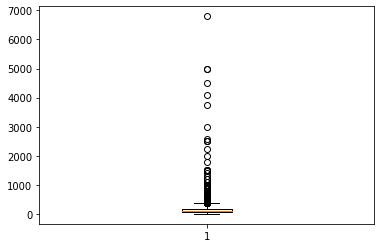

In [9]:
# boxplot of the price values, we see a lot of outliers
plt.boxplot(df_red.price);

In [10]:
# with quantiles
df_red.price.quantile([0.25,0.5,0.75,0.95])

0.25     70.0
0.50    110.0
0.75    186.0
0.95    399.0
Name: price, dtype: float64

In [11]:
# Because it's hard to deal with outliers in ML, we decide to only keep airbnbs with a price less than the 0.95 quantile
# Also, we make the assumption that close AirBnb are about the same pricethe goal is to find best airbnb, so best value for money.
upper_bound = df_red.price.quantile([0.95]).values[0]
df_red = df_red[df_red.price <= upper_bound]
df_red.shape

(4755, 13)

In [12]:
# standardizing the UTM coordinates
df_red.utm_x = (df_red.utm_x - df_red.utm_x.mean()) / df_red.utm_x.std()
df_red.utm_y = (df_red.utm_y - df_red.utm_y.mean()) / df_red.utm_y.std()
df_coord = df_red[['utm_x', 'utm_y']]

In [13]:
df_coord.head()

,utm_x,utm_y
15798,-0.365937,0.580090
44065,-0.990046,0.227610
46315,3.168360,0.599703
2647,-1.309758,-0.911182
13805,0.363898,-0.478423


In [41]:
# computing distance between all airbnbs.
from scipy.spatial.distance import squareform, pdist
df_dist = pd.DataFrame(squareform(pdist(df_coord.iloc[ :, 0:])), columns=df_coord.index, index=df_coord.index)

In [42]:
df_dist.head()

,15798,44065,46315,2647,13805,30989,12238,25538,40356,40287,...,21009,46961,30665,33976,36670,36221,21970,39628,46991,32698
15798,0.000000,0.716767,3.534351,1.764849,1.285732,1.845839,0.471759,4.547376,0.586882,0.187982,...,2.099131,1.245992,2.196346,2.543072,1.350018,0.740253,0.475870,4.226575,0.943853,1.521296
44065,0.716767,0.000000,4.175020,1.182820,1.526973,2.416884,0.935637,5.182765,0.278077,0.900888,...,2.654907,1.836980,2.177469,3.188312,1.663326,0.401294,1.168858,4.693931,0.345630,1.844240
46315,3.534351,4.175020,0.000000,4.726131,3.004557,1.804695,3.701907,1.013516,4.117167,3.397439,...,1.619761,3.365931,3.530021,0.991279,2.816094,3.946084,3.266894,1.735079,4.231004,2.699155
2647,1.764849,1.182820,4.726131,0.000000,1.728700,2.927398,2.099872,5.687325,1.459259,1.946915,...,3.108523,2.986853,1.745296,3.798026,1.916919,1.027262,2.239401,4.825417,0.851182,2.055035
13805,1.285732,1.526973,3.004557,1.728700,0.000000,1.224761,1.742347,3.958759,1.637763,1.324819,...,1.384795,2.273433,1.024344,2.106820,0.188648,1.158892,1.504456,3.209002,1.412071,0.340878


In [43]:
df_knn = df_dist.copy()

# Get the k nearest neighbour from each node
for column in df_knn:
    column_values = df_dist[column].to_numpy() # Transforming column of dataframe into numpy array
    number_of_neighbour = 101 # Number of neighbour we want
    result = np.argpartition(column_values, number_of_neighbour) # Get indexes from min values
    min_values = column_values[result[:number_of_neighbour]] # Get min values from indexes
    min_values_sorted = np.sort(min_values) # Sort the min values
    threshold = min_values_sorted[-1] # taking the max of the min values to thersold
    df_knn[column] = df_knn[column].where(df_knn[column] <= threshold, 0)
    
df_knn.head()

,15798,44065,46315,2647,13805,30989,12238,25538,40356,40287,...,21009,46961,30665,33976,36670,36221,21970,39628,46991,32698
15798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.187982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.013516,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
mean = df_dist.mean().mean()
print('The mean distance is {m}'.format(m=mean))

The mean distance is 1.6978275989070877


In [48]:
epsilon = 0.2
sigma = mean * 0.7
def sparsify(x):
    sigm_x = np.exp(- x**2 / (2*sigma**2))
    if sigm_x < epsilon:
        return 0
    return sigm_x

In [49]:
# compute weights of the edges, sparsifying.
df_dist_s = df_dist.applymap(sparsify)
print('there are {i} non-zero entries'.format(i = df_dist_s.astype(bool).sum().sum()))

there are 16277659 non-zero entries


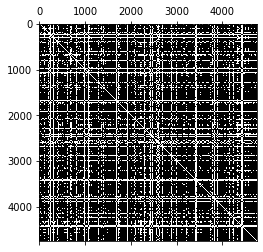

In [50]:
# create adjacency matrix, as a numpy array
adj_dist = df_dist_s.values - np.eye(df_dist_s.shape[0])
plt.spy(adj_dist)
plt.show()

In [51]:
# dictionnary to rename the labels of the nodes according to their indice in the df
nodes_labels = dict(zip(np.arange(n), df_dist_s.index))

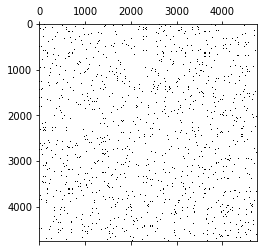

In [58]:
df_knn = df_knn.astype(bool)
adj_knn = np.logical_or(df_knn.values, df_knn.values.T)
plt.spy(adj_knn)
plt.show()

In [59]:
adj = adj_knn

#### Exploration | Using NetworkX for vizualization (it's faster than pygsp)
Inspecting some of the features

In [60]:
# different neighbourhood
df_red.neighbourhood_group.value_counts()

Manhattan        1968
Brooklyn         1916
Queens            695
Bronx             123
Staten Island      53
Name: neighbourhood_group, dtype: int64

In [61]:
# different room types
df_red.room_type.value_counts()

Entire home/apt    2427
Private room       2193
Shared room         135
Name: room_type, dtype: int64

In [62]:
# create networkx graph, renaming nodes
import networkx as nx

G = nx.from_numpy_matrix(adj)
G = nx.relabel_nodes(G, nodes_labels)

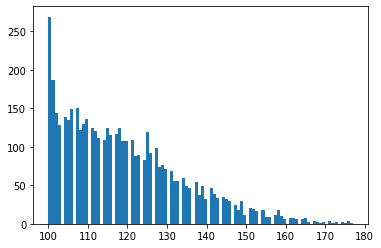

In [63]:
# Plotting the degree distribution
plt.hist([G.degree(n) for n in G.nodes()], bins=100)
plt.show()

In [67]:
degree_distri = np.asarray([G.degree(n) for n in G.nodes()])
average_degree = (1/G.number_of_nodes())*degree_distri.sum()
print(average_degree)

119.1011566771819


In [65]:
#nx.average_clustering(G)

In [66]:
# DON'T RUN IF NO CONNECTED GRAPH
# check if the graph is connected, and compute the diameter
# epsilon=0.2 and c=0.7 gives connected graph for n=5000 but doesn't work with spectral clustering...
# epsilon=0.5 and c=0.1 gives not connected graph for n=5000 but work with spectral clustering (3 clusters)...
diameter_matrix = np.zeros([len(adj), len(adj)])

# loop until all elements are non-zero
diameter = -1
for i in range(0, 10):
    diameter_matrix += np.linalg.matrix_power(adj, i)
    if diameter_matrix.all() == True:
        diameter = i
        break

print(f"The diameter is: {diameter}")

KeyboardInterrupt: 

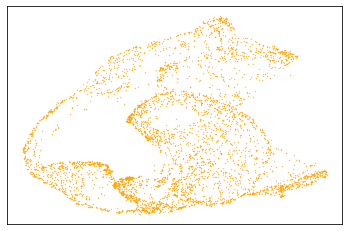

In [29]:
# Network visualization without fixing the position of nodes i.e. based only on distances between them
nx.draw_networkx(G, with_labels=False, node_size=0.1, node_color='orange', width=0.05, edgelist=[])
plt.show()

In [68]:
# create dictionnary for nodes positions (such that the graph is plotted accordinf to NY shape)
coord_dict = df_red.utm.to_dict()

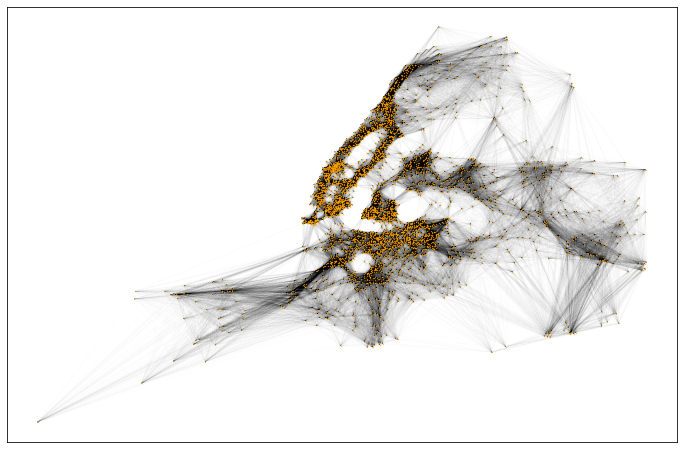

In [125]:
# graph of the airbnb with fixed position
# take time when lot of edges, set edgelist=[] or remove 'edgelist' parameter to plot edges
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=0.1, node_color='orange', width=0.005)
plt.show()

In [70]:
# We plot the airbnb with different color according to their neighbouhood

neighbourhoud_to_int = {
    'Manhattan': 1,
    'Brooklyn': 2,
    'Queens': 3,
    'Bronx': 4,
    'Staten Island': 5
}

In [71]:
# transforming neigbourhood names and room types strings into an indice
df_red['neighbourhood_group_indice'] = df_red.neighbourhood_group.apply(lambda x: neighbourhoud_to_int.get(x)).values

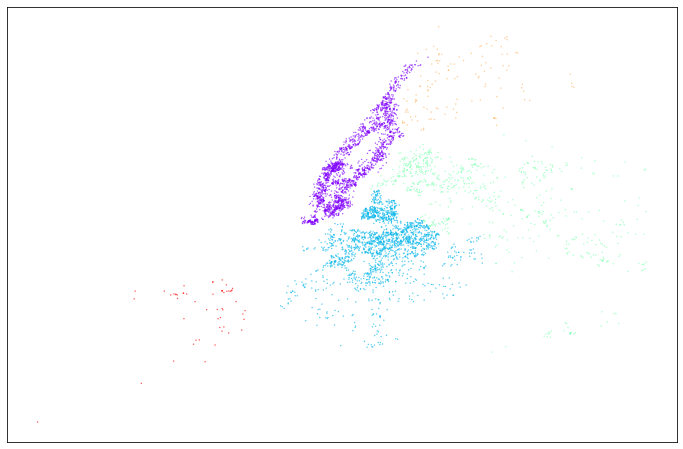

In [72]:
# graph of the airbnb with groundtruth
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=df_red.neighbourhood_group_indice, edgelist=[])
plt.show()

In [73]:
#Graph analysis with gsp
from pygsp import graphs, filters, plotting
from pygsp.graphs import Graph

G_gsp = graphs.Graph(adj)

In [74]:
G_gsp.is_connected()

True

In [75]:
G_gsp.set_coordinates(kind=np.array(list(coord_dict.values())))

In [76]:
# computing laplacian of graph
lap_comb = G_gsp.compute_laplacian(lap_type='combinatorial') # 'combinatorial' or 'normalized'

# computing eigendecomposition of the laplacian
G_gsp.compute_fourier_basis(recompute=True)

2020-01-09 20:13:19,054:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4755 x 4755) may take some time.


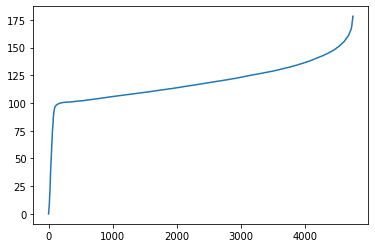

In [77]:
plt.plot(G_gsp.e);

In [78]:
# computing laplacian of graph
lap_norm = G_gsp.compute_laplacian(lap_type='normalized') # 'combinatorial' or 'normalized'

# computing eigendecomposition of the laplacian
G_gsp.compute_fourier_basis(recompute=True)

2020-01-09 20:13:30,488:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4755 x 4755) may take some time.


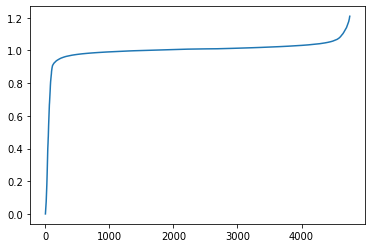

In [79]:
plt.plot(G_gsp.e);

In [80]:
# an eigenvector
eigenevector_index = 0
#G_gsp.U[:,eigenevector_index]

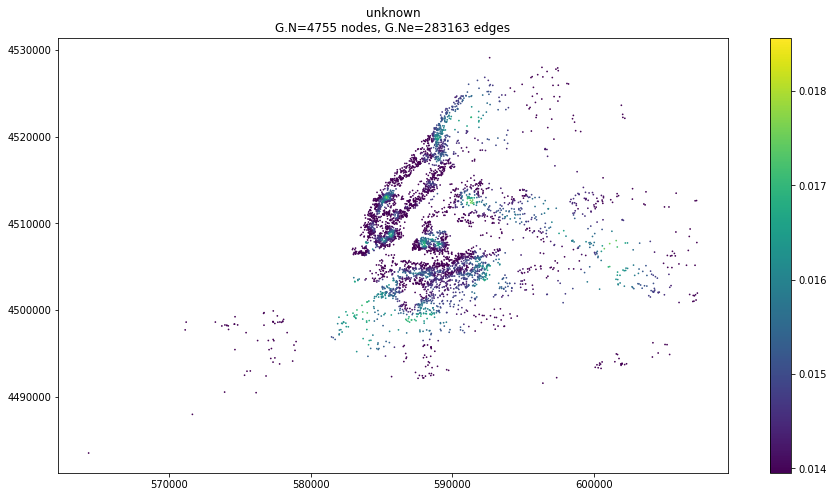

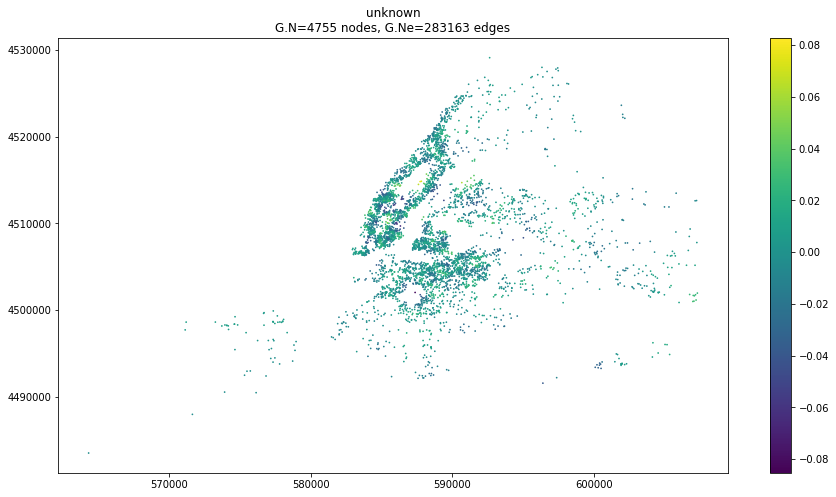

In [83]:
# plot of one of the eigenvector
eigenevector_index = 0
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=G_gsp.U[:, eigenevector_index],vertex_size=0.5,ax=axes)

# WHY FIRST EIGENVECTOR NOT CONSTANT ????

eigenevector_index = 100
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=G_gsp.U[:, eigenevector_index],vertex_size=0.5,ax=axes)

### Using spectral clustering to identify the neighbourhoods

In [ ]:
# we keep only the greatest connected component (if graph is not connected)
# not very useful to run spectral clustering on disconnected graph
Gc = max(nx.connected_component_subgraphs(G), key=len)

In [ ]:
Gc_nodes = max(nx.connected_components(G), key=len)

In [ ]:
# plotting greatest component
plt.figure(figsize=(12,8))
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, node_color='orange', width=0.05, edgelist=[])
plt.show()

Running spectral clustering on the biggest connected component

In [ ]:
# adacency matrix of gc
adj_c = nx.adjacency_matrix(Gc)

In [84]:
# computing labels from spectral clustering
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, eigen_solver='amg', affinity='precomputed', n_init=100)
sc.fit(adj)

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:286: UserWarning: AMG works better for sparse matrices
  warnings.warn("AMG works better for sparse matrices")
/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pyamg/aggregation/aggregation.py:218: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
                   degree=3, eigen_solver='amg', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=3, n_init=100, n_jobs=None,
                   n_neighbors=10, random_state=None)

In [ ]:
# displaying result of spectrcal clustering
plt.figure(figsize=(12,8))
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=sc.labels_, width=0.05, edgelist=[])
plt.show()

### Using PyGSP for graph spectral analysis

In [85]:
from pygsp import graphs, filters, plotting
from pygsp.graphs import Graph

In [86]:
G_gsp = graphs.Graph(adj) # using adj and not adj_c, we need the whole graph
print('{} nodes, {} edges'.format(G_gsp.N, G_gsp.Ne))

4755 nodes, 283163 edges


In [87]:
G_gsp.is_connected()

True

In [88]:
G_gsp.set_coordinates(kind=np.array(list(coord_dict.values())))

### Computing laplacian 

In [89]:
# computing laplacian of graph
G_gsp.compute_laplacian(lap_type='normalized') # 'combinatorial' or 'normalized'

In [90]:
# computing eigendecomposition of the laplacian
G_gsp.compute_fourier_basis(recompute=True)

2020-01-09 20:15:04,669:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4755 x 4755) may take some time.


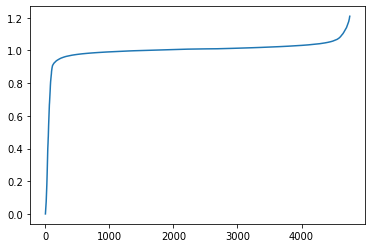

In [91]:
# plot of the eigenvalues
plt.plot(G_gsp.e);

In [92]:
# an eigenvector
eigenevector_index = 0
G_gsp.U[:,eigenevector_index]

array([0.0139368 , 0.01361637, 0.01368106, ..., 0.01479713, 0.01449573,
       0.01543951])

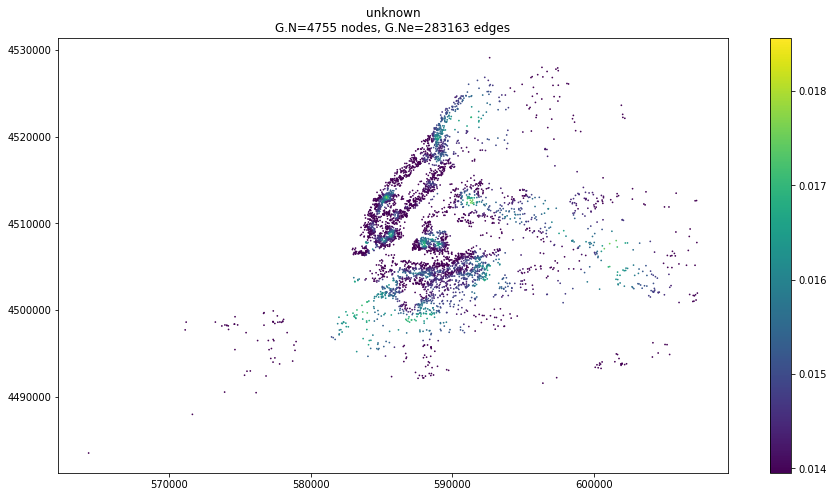

In [93]:
# plot of one of the eigenvector
eigenevector_index = 0
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=G_gsp.U[:, eigenevector_index],vertex_size=0.5,ax=axes)

# WHY FIRST EIGENVECTOR NOT CONSTANT ????

### Prediction of the price

The goal of this section is the predict the price of airbnbs. We will first use Machine Learning techniques, and then spectral filtering to improve the result. We'll use the assumptions that close airbnbs should have close price.

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


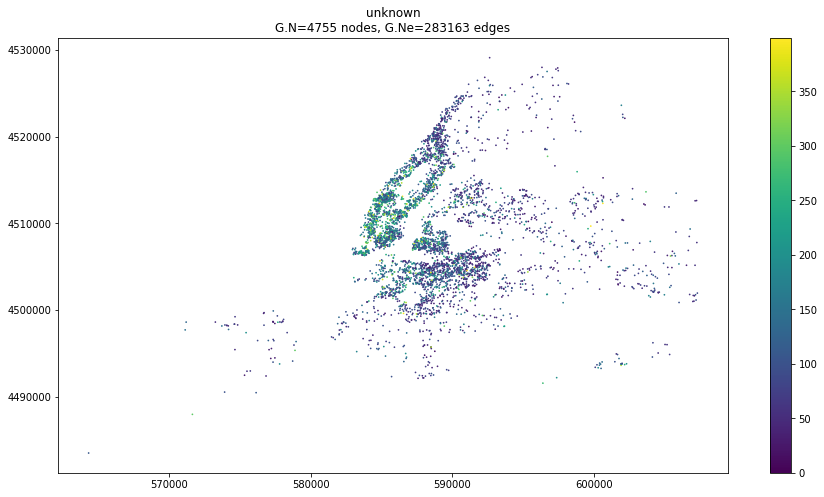

In [94]:
# groundtruth of the price
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=df_red.price,vertex_size=0.5, limits=[0, upper_bound], ax=axes)

In [95]:
shuffled_index = df_red.sample(frac=1).index
reordered_index = df_red.index
df_red.fillna(0, inplace=True) # there are nan values in 'last_review' and 'reviews_per_month' features
df_red.head(1)

,id,host_id,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,utm,utm_x,utm_y,neighbourhood_group_indice
15798,12778678,45595980,Manhattan,Midtown,Entire home/apt,140,5,0.15,12,290,"(587257.9946750912, 4512683.725555462)",-0.365937,0.58009,1


In [96]:
def normalize_serie(x):
    return (x - x.mean())/x.std()

In [97]:
# creating new features for machine learning 
df_red['manhattan'] = (df_red.neighbourhood_group == 'Manhattan').astype(int)
df_red['brooklyn'] = (df_red.neighbourhood_group == 'Brooklyn').astype(int)
df_red['queens'] = (df_red.neighbourhood_group == 'Queens').astype(int)
df_red['bronx'] = (df_red.neighbourhood_group == 'Bronx').astype(int)
df_red['staten_island'] = (df_red.neighbourhood_group == 'Staten Island').astype(int)
df_red['home'] = (df_red.room_type == 'Entire home/apt').astype(int)
df_red['private_room'] = (df_red.room_type == 'Private room').astype(int)
df_red['shared_room'] = (df_red.room_type == 'Shared room').astype(int)

In [98]:
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize, StandardScaler

In [99]:
df_red.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'room_type',
       'price', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'utm', 'utm_x',
       'utm_y', 'neighbourhood_group_indice', 'manhattan', 'brooklyn',
       'queens', 'bronx', 'staten_island', 'home', 'private_room',
       'shared_room'],
      dtype='object')

In [100]:
# suffling the data
df_red.reindex(shuffled_index)

# features when need to predict the price
features_to_augment = df_red[['utm_x', 'utm_y']].values
features_neighbourhood = df_red[['brooklyn', 'queens', 'bronx', 'staten_island']].values
features_basics = df_red[['number_of_reviews', 'reviews_per_month', 'availability_365', 'calculated_host_listings_count', 'home', 'private_room', 'shared_room']].values
features_known = df_red[['calculated_host_listings_count', 'home', 'private_room', 'shared_room']].values



In [101]:
# augmenting features
def build_poly(x, degree):
    """build polynomial for ridge regression"""
    nb_features = x.shape[1]
    nb_samples = x.shape[0]
    x_poly = np.ones((nb_samples, 1))
    for d in range(1, degree + 1):
        x_d = x**d
        x_poly = np.hstack((x_poly, x_d))
    return x_poly

In [102]:
features_augmented = build_poly(features_to_augment, 3)
# features = np.hstack((features_augmented, features_neighbourhood, features_known))
features = np.hstack((features_neighbourhood, features_known))
# features = features_basics

In [103]:
# building a 5-fold ridge regression
rr = RidgeCV(fit_intercept=False, normalize=False, cv=5, alphas=np.logspace(-5, -1, 20))
rr.fit(X=features, y=df_red.price.values)

RidgeCV(alphas=array([1.00000000e-05, 1.62377674e-05, 2.63665090e-05, 4.28133240e-05,
       6.95192796e-05, 1.12883789e-04, 1.83298071e-04, 2.97635144e-04,
       4.83293024e-04, 7.84759970e-04, 1.27427499e-03, 2.06913808e-03,
       3.35981829e-03, 5.45559478e-03, 8.85866790e-03, 1.43844989e-02,
       2.33572147e-02, 3.79269019e-02, 6.15848211e-02, 1.00000000e-01]),
        cv=5, fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [104]:
# predicting the price 
price_pred_1 = rr.predict(X=features)
price_pred_1

array([194.79568287, 193.11666135,  66.77363002, ..., 151.79424609,
       108.70659855, 156.94370457])

In [105]:
mse_1 = mean_squared_error(y_true=df_red.price.values, y_pred=price_pred_1)
mse_1

3623.297491849557

In [106]:
df_red['price_pred_1'] = price_pred_1
df_red.reindex(reordered_index).head(1)

,id,host_id,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,...,neighbourhood_group_indice,manhattan,brooklyn,queens,bronx,staten_island,home,private_room,shared_room,price_pred_1
15798,12778678,45595980,Manhattan,Midtown,Entire home/apt,140,5,0.15,12,290,...,1,1,0,0,0,0,1,0,0,194.795683


/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


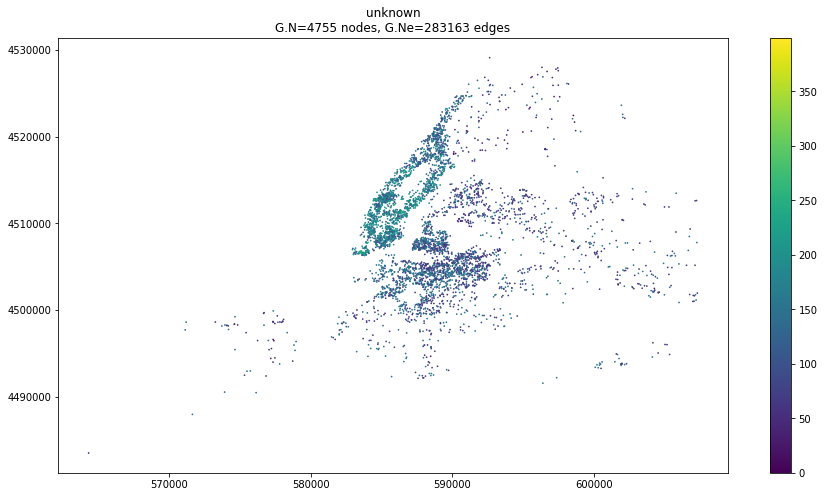

In [107]:
# predicted price using only ML techniques
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=df_red.price_pred_1, vertex_size=0.5, limits=[0, upper_bound], ax=axes)

### Now let's assume that the price is a signal on our graph

In [108]:
def GFT(signal: np.ndarray):
    return G_gsp.U.T @ signal

def iGFT(fourier_coefficients: np.ndarray):
    return G_hsp.U @ fourier_coefficients

[]

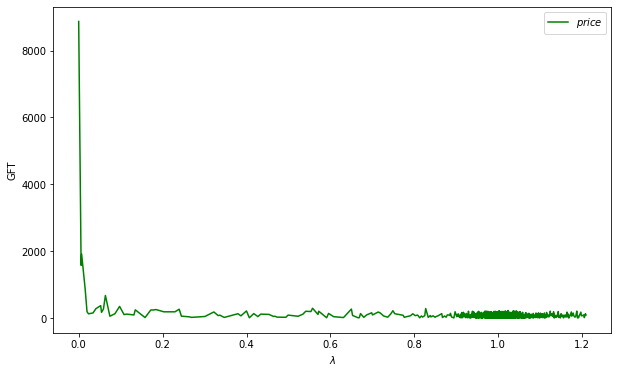

In [109]:
# graph spectrum of the price signal
plt.figure(figsize=(10, 6))
plt.plot(G_gsp.e, np.abs(GFT(df_red.price)), 'g-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$price$', '$x$'])
plt.plot()

[]

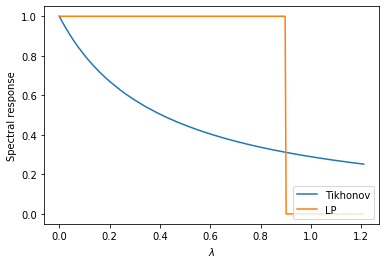

In [110]:
# ideal Tikhonov regularization filter
c = 3
# 6 gives good results for basics_features, 3 for features with neighbourhoods

alpha = 0.99 / (np.max(G_gsp.e) / c)
ideal_tk =  1 / (1 + alpha * G_gsp.e)

# low-pass filter
ideal_lp = np.ones((G_gsp.N,))
threshold = 0.9
ideal_lp[G_gsp.e >= threshold] = 0

plt.plot(G_gsp.e, ideal_tk, '-', label='Tikhonov')
plt.plot(G_gsp.e, ideal_lp, '-', label='LP')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')
plt.plot()

In [111]:
ideal_filter = ideal_tk

In [112]:
# order will be the maximum degree of the polynomial, so there will be order+1 coefficients
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    vdmd = np.vander(np.sort(lam), order+1, increasing=True)
    c, res, rank, s = np.linalg.lstsq(vdmd, spectral_response, rcond=None) # we work in the frequency domain
    return c

In [113]:
def polynomial_graph_filter(coeff: np.array):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    e_values = G_gsp.e
    e_vectors = G_gsp.U
    e_values_filter = polynomial_graph_filter_response(coeff, e_values)
    return e_vectors @ np.diag(e_values_filter) @ e_vectors.T

In [114]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    response = np.zeros(lam.shape[0])
    order = coeff.shape[0]
    for i in range(response.shape[0]): 
        for k in range(order):
            response[i] += coeff[k]*lam[i]**k
    return response

In [115]:
order =  5

coeff = fit_polynomial(G_gsp.e, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff)

Text(0, 0.5, 'Spectral response')

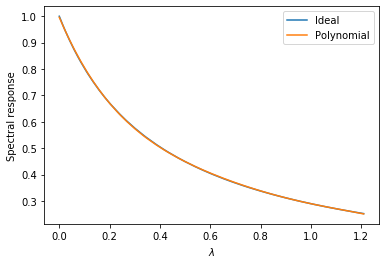

In [116]:
plt.plot(G_gsp.e, ideal_filter)
plt.plot(G_gsp.e, polynomial_graph_filter_response(coeff, G_gsp.e))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

In [117]:
filtered_features = graph_filter @ features
df_red.reindex(shuffled_index);

In [118]:
rr.fit(X=filtered_features, y=df_red.price.values)

RidgeCV(alphas=array([1.00000000e-05, 1.62377674e-05, 2.63665090e-05, 4.28133240e-05,
       6.95192796e-05, 1.12883789e-04, 1.83298071e-04, 2.97635144e-04,
       4.83293024e-04, 7.84759970e-04, 1.27427499e-03, 2.06913808e-03,
       3.35981829e-03, 5.45559478e-03, 8.85866790e-03, 1.43844989e-02,
       2.33572147e-02, 3.79269019e-02, 6.15848211e-02, 1.00000000e-01]),
        cv=5, fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [119]:
# predicting the price 
price_pred_2 = rr.predict(X=filtered_features)

In [120]:
mse_2 = mean_squared_error(y_true=df_red.price.values, y_pred=price_pred_2)
mse_2

3442.5998121000903

In [121]:
df_red['price_pred_2'] = price_pred_2
df_red.reindex(reordered_index);

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


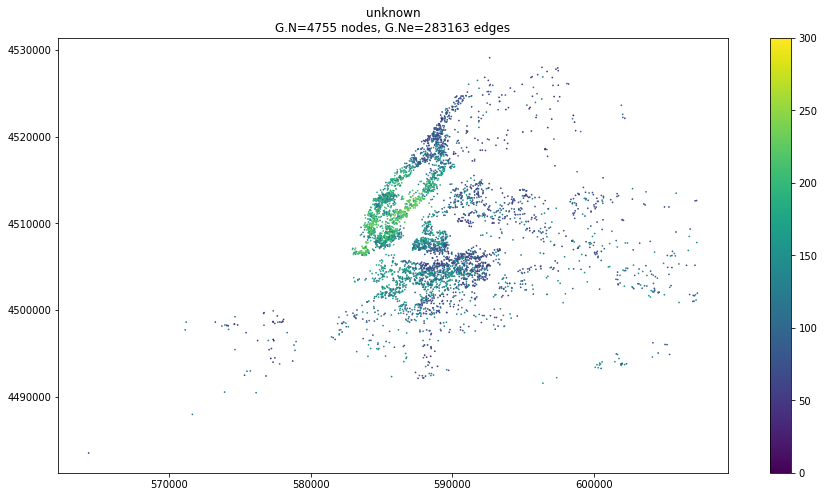

In [122]:
# plot the predicted price - very different from the groundtruth!
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=df_red.price_pred_2, vertex_size=0.5, limits=[0,300], ax=axes)

In [123]:
print('the price are now more accurate of {:.3f} in average'.format(np.sqrt(mse_1 - mse_2)))

the price are now more accurate of 13.442 in average


### Using Neural Netowrks

In [ ]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D
import tensorflow as tf

In [ ]:
features_size = features.shape[1]

# Neural network
model = Sequential()
model.add(Conv1D(filters=3, kernel_size=2, activation='relu', input_dim=features_size))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

In [ ]:
df_red.reindex(shuffled_index)
history = model.fit(filtered_features, df_red.price, epochs=100, batch_size=4)

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()